In [1]:
#simple chatbot to determine yes/no based on a given story

import pickle
import numpy as np

with open("train_qa.txt", "rb") as fp:   # Unpickling
    train_data =  pickle.load(fp)
    
with open("test_qa.txt", "rb") as fp:   # Unpickling
    test_data =  pickle.load(fp)

In [2]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [3]:
# Create a set that holds the vocab words
vocab = set()

all_data = test_data + train_data

for story, question , answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

vocab.add('no')
vocab.add('yes')

In [4]:
vocab_size = len(vocab) + 1 #+1 for Keras' pad_sequences

max_story_len = max([len(data[0]) for data in all_data])
max_question_len = max([len(data[1]) for data in all_data])

In [5]:
# Vectorizing the data
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# integer encode sequences of words
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

# train/test split
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

# creating a sequence of texts for train set
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [6]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers
        # Index 0 is reserved
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [7]:
# unpacking vectorized train/test sets
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [8]:
# Creating the model

from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

# placeholders for inputs
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))

# encode input sequence and questions
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)  # (samples, 32)

# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# train (comment out if not training)
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/120
313/313 [==============================] - 5s 10ms/step - loss: 1.1889 - accuracy: 0.4819 - val_loss: 0.6940 - val_accuracy: 0.4970
Epoch 2/120
313/313 [==============================] - 2s 7ms/step - loss: 0.7025 - accuracy: 0.5053 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 3/120
313/313 [==============================] - 2s 7ms/step - loss: 0.6961 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 4/120
313/313 [==============================] - 2s 7ms/step - loss: 0.6951 - accuracy: 0.4990 - val_loss: 0.7011 - val_accuracy: 0.4970
Epoch 5/120
313/313 [==============================] - 2s 7ms/step - loss: 0.6949 - accuracy: 0.5092 - val_loss: 0.6952 - val_accuracy: 0.5030
Epoch 6/120
313/313 [==============================] - 2s 7ms/step - loss: 0.6945 - accuracy: 0.4955 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 7/120
313/313 [==============================] - 2s 7ms/step - loss: 0.6945 - accuracy: 0.5059 - val_loss: 0.6935 - val_accuracy: 0.503

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


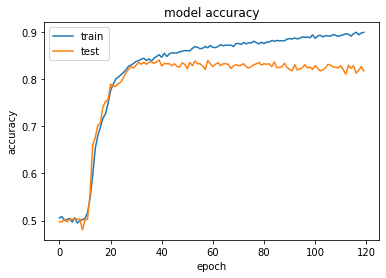

In [30]:
#plotting out training history
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# comment this cell out of not training
filename = 'chatbot_120_epochs_v2.h5'
model.save(filename)

In [26]:
# Evaluating on a given test set
# input model into filename
model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

In [27]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

# Displaying story and prediction

story =' '.join(word for word in test_data[0][0])
print(story)

query = ' '.join(word for word in test_data[0][1])
print(query)

print("True Test Answer from Data is:",test_data[0][2])

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Mary got the milk there . John moved to the bedroom .
Is John in the kitchen ?
True Test Answer from Data is: no
Predicted answer is:  no
Probability of certainty was:  0.9998342


In [28]:
# we can only use words from the vocab
', '.join(vocab)

'back, there, garden, down, no, John, put, ., ?, bathroom, Sandra, grabbed, left, journeyed, hallway, Mary, football, went, to, yes, moved, up, apple, milk, the, took, kitchen, got, dropped, Is, office, Daniel, in, picked, bedroom, travelled, discarded'

In [29]:
# Using my own story and question
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

my_question = "Is the football in the garden ?"

print('Story: ', my_story)
print('Question: ',my_question)

mydata = [(my_story.split(),my_question.split(),'yes')]
my_story,my_ques,my_ans = vectorize_stories(mydata)
pred_results = model.predict(([ my_story, my_ques]))

#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Story:  John left the kitchen . Sandra dropped the football in the garden .
Question:  Is the football in the garden ?
Predicted answer is:  yes
Probability of certainty was:  0.9962836
